# Timeseries Forecasting
Francois Chollet, Deep Learning with Python, chapter 10.  
Data:  https://www.kaggle.com/datasets/mnassrib/jena-climate?resource=download

In [27]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

### Import Data

In [4]:
with open('jena_climate_2009_2016.csv') as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [6]:
temp = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temp[i] = values[1]
    raw_data[i, :] = values[:]

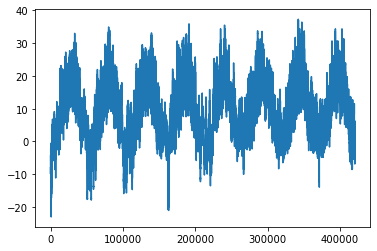

In [9]:
plt.plot(temp);

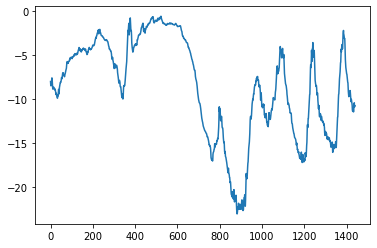

In [18]:
plt.plot(temp[:1440]);

In [12]:
# split data to train 50%, validate 25%, test 25%
num_train = int(0.5 * len(raw_data))
num_val = int(0.25 * len(raw_data))
num_test = len(raw_data) - num_train - num_val

In [19]:
# normalise the data
mean = raw_data[:num_train].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train].std(axis=0)
raw_data /= std

In [20]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)  # sample to forecast
batch_size = 256

# create three Dataset objects
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train,
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train,
    end_index=num_train + num_val,
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train + num_val,
)

In [21]:
# each iteration yields a batch of data and targets
for samples, targets in train_dataset:
    print(samples.shape)
    print(targets.shape)
    break

(256, 120, 14)
(256,)


## Baseline
Establish a baseline where predicted temperature is the tempreture reading 24h in the past.

In [23]:
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    for samples, targets in dataset:
        # get last temperature, which is in column 1
        # unnormalise data
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
        return total_abs_err / samples_seen

In [26]:
print('Validation dataset MAE:', evaluate_naive_method(val_dataset), 'deg')
print('Test dataset MAE:', evaluate_naive_method(test_dataset), 'deg')

Validation dataset MAE: 2.363203125 deg
Test dataset MAE: 2.7439843749999997 deg


### Fully Connected NN
In forecasting problems last layer does not have an activation function.

In [50]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint('jena_dense.keras', save_best_only=True)]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 10s 11ms/step - loss: 12.7917 - mae: 2.7606 - val_loss: 12.3801 - val_mae: 2.7992
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 9.1618 - mae: 2.3792 - val_loss: 11.1270 - val_mae: 2.6488
Epoch 3/10
819/819 [==============================] - 10s 12ms/step - loss: 8.4203 - mae: 2.2845 - val_loss: 10.0152 - val_mae: 2.5030
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 7.9315 - mae: 2.2169 - val_loss: 9.9748 - val_mae: 2.5002
Epoch 5/10
819/819 [==============================] - 10s 12ms/step - loss: 7.5616 - mae: 2.1647 - val_loss: 11.5461 - val_mae: 2.6999
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 7.3194 - mae: 2.1305 - val_loss: 11.2316 - val_mae: 2.6567
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 7.1293 - mae: 2.1025 - val_loss: 11.0110 - val_mae: 2.6320
Epoch 8/10
819/819 [==============================] - 1

In [51]:
model = keras.models.load_model('jena_dense.keras')
eval = model.evaluate(test_dataset)

405/405 [==============================] - 3s 7ms/step - loss: 6526.2231 - mae: 8.3548


In [53]:
def plot_history(history):
    loss = history.history['mae']
    val_loss = history.history['val_mae']
    plt.figure()
    plt.plot(loss, label='Training MAE')
    plt.plot(val_loss, label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.legend()
    plt.show()

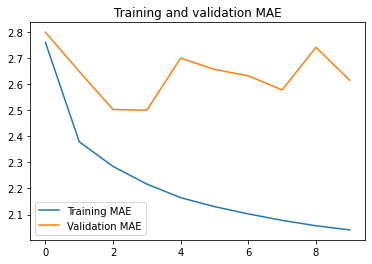

In [54]:
plot_history(history)

### 1D Convolution
Conv filters can extract patterns whereby the process is invariant to the window position (translation invariance assumption on time series). The underlying problem is that timeseries data is not translation invariant.

In [40]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint('jena_conv.keras', save_best_only=True)]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset, 
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 21s 25ms/step - loss: 78.7655 - mae: 7.1814 - val_loss: 65.2663 - val_mae: 6.6509
Epoch 2/10
819/819 [==============================] - 20s 25ms/step - loss: 76.4756 - mae: 7.0849 - val_loss: 66.7984 - val_mae: 6.7272
Epoch 3/10
819/819 [==============================] - 20s 25ms/step - loss: 76.4263 - mae: 7.0823 - val_loss: 65.2030 - val_mae: 6.6483
Epoch 4/10
819/819 [==============================] - 20s 25ms/step - loss: 76.4161 - mae: 7.0823 - val_loss: 68.5701 - val_mae: 6.8099
Epoch 5/10
819/819 [==============================] - 20s 25ms/step - loss: 76.3728 - mae: 7.0796 - val_loss: 66.0547 - val_mae: 6.6919
Epoch 6/10
819/819 [==============================] - 20s 25ms/step - loss: 76.3905 - mae: 7.0807 - val_loss: 65.8682 - val_mae: 6.6826
Epoch 7/10
819/819 [==============================] - 20s 25ms/step - loss: 76.3525 - mae: 7.0793 - val_loss: 64.9288 - val_mae: 6.6330
Epoch 8/10
819/819 [============================

In [41]:
model = keras.models.load_model('jena_conv.keras')
eval = model.evaluate(test_dataset)
print('Test MAE:', eval[1])

405/405 [==============================] - 4s 9ms/step - loss: 4978.5396 - mae: 10.2715
Test MAE: 10.271482467651367


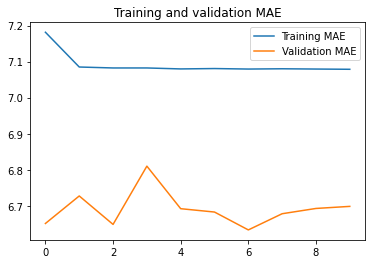

In [42]:
plot_history(history)

### LSTM

In [44]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1984      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [45]:
callbacks = [keras.callbacks.ModelCheckpoint('jena_lstm.keras', save_best_only=True)]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 48s 57ms/step - loss: 46.4347 - mae: 4.9968 - val_loss: 13.7073 - val_mae: 2.8129
Epoch 2/10
819/819 [==============================] - 47s 58ms/step - loss: 11.4104 - mae: 2.6179 - val_loss: 9.4268 - val_mae: 2.4041
Epoch 3/10
819/819 [==============================] - 47s 58ms/step - loss: 9.8742 - mae: 2.4498 - val_loss: 9.5381 - val_mae: 2.4089
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 9.3621 - mae: 2.3846 - val_loss: 9.4847 - val_mae: 2.4065
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 8.9761 - mae: 2.3332 - val_loss: 9.2918 - val_mae: 2.3827
Epoch 6/10
819/819 [==============================] - 47s 58ms/step - loss: 8.6441 - mae: 2.2873 - val_loss: 9.2358 - val_mae: 2.3783
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 8.3628 - mae: 2.2503 - val_loss: 9.4954 - val_mae: 2.4193
Epoch 8/10
819/819 [==============================] - 48s 5

In [46]:
model = keras.models.load_model('jena_lstm.keras')
eval = model.evaluate(test_dataset)
print('Test MAE:', eval[1])

405/405 [==============================] - 9s 22ms/step - loss: 10.6470 - mae: 2.5545
Test MAE: 2.554539203643799


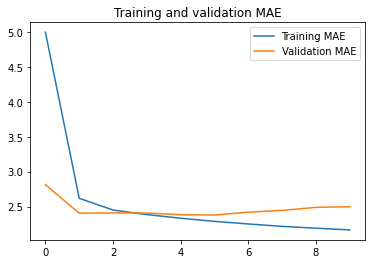

In [49]:
plot_history(history)

### LSTM with Droput

In [56]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint('jena_lstm_droput.keras', save_best_only=True)]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 78s 93ms/step - loss: 27.5379 - mae: 3.8716 - val_loss: 9.7503 - val_mae: 2.4283
Epoch 2/50
819/819 [==============================] - 77s 93ms/step - loss: 14.9064 - mae: 2.9982 - val_loss: 9.6598 - val_mae: 2.4194
Epoch 3/50
819/819 [==============================] - 77s 94ms/step - loss: 13.9570 - mae: 2.8946 - val_loss: 9.3951 - val_mae: 2.3834
Epoch 4/50
819/819 [==============================] - 78s 96ms/step - loss: 13.3241 - mae: 2.8293 - val_loss: 9.5780 - val_mae: 2.4205
Epoch 5/50
819/819 [==============================] - 79s 96ms/step - loss: 12.8543 - mae: 2.7798 - val_loss: 9.3215 - val_mae: 2.3753
Epoch 6/50
819/819 [==============================] - 80s 97ms/step - loss: 12.5088 - mae: 2.7412 - val_loss: 9.0725 - val_mae: 2.3534
Epoch 7/50
819/819 [==============================] - 80s 98ms/step - loss: 12.2167 - mae: 2.7082 - val_loss: 9.4047 - val_mae: 2.3963
Epoch 8/50
819/819 [==============================] - 8

In [57]:
model = keras.models.load_model('jena_lstm_droput.keras')
eval = model.evaluate(test_dataset)
print('Test MAE:', eval[1])

405/405 [==============================] - 10s 24ms/step - loss: 10.6263 - mae: 2.5784
Test MAE: 2.578418016433716


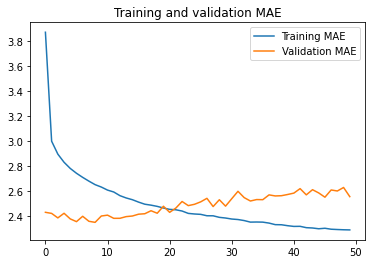

In [58]:
plot_history(history)

### Stacking RNNs

In [61]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint('jena_stacked_gru_dropout.keras', save_best_only=True)]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 146s 175ms/step - loss: 26.2632 - mae: 3.7644 - val_loss: 9.5563 - val_mae: 2.3858
Epoch 2/10
819/819 [==============================] - 145s 176ms/step - loss: 13.9938 - mae: 2.8943 - val_loss: 9.7380 - val_mae: 2.4289
Epoch 3/10
819/819 [==============================] - 146s 178ms/step - loss: 13.1441 - mae: 2.8095 - val_loss: 9.3985 - val_mae: 2.3778
Epoch 4/10
819/819 [==============================] - 146s 178ms/step - loss: 12.6623 - mae: 2.7570 - val_loss: 9.0688 - val_mae: 2.3370
Epoch 5/10
819/819 [==============================] - 148s 180ms/step - loss: 12.1721 - mae: 2.7054 - val_loss: 9.3470 - val_mae: 2.3784
Epoch 6/10
819/819 [==============================] - 148s 180ms/step - loss: 11.7602 - mae: 2.6576 - val_loss: 9.1984 - val_mae: 2.3665
Epoch 7/10
819/819 [==============================] - 148s 181ms/step - loss: 11.3942 - mae: 2.6186 - val_loss: 9.5474 - val_mae: 2.4002
Epoch 8/10
819/819 [=====================

In [62]:
model = keras.models.load_model('jena_stacked_gru_dropout.keras')
eval = model.evaluate(test_dataset)
print('Test MAE:', eval[1])

405/405 [==============================] - 16s 39ms/step - loss: 9.8799 - mae: 2.4558
Test MAE: 2.455833911895752


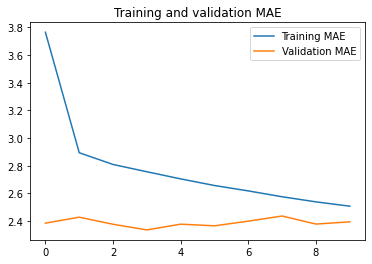

In [63]:
plot_history(history)

### Bidirectional RNNs
Does not outperform forward directional models in this case, as later data samples have higher predictional power and therefore the antichronological branch reduces accuracy.

In [65]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint('jena_bidirectional_lstm.keras', save_best_only=True)]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 56s 66ms/step - loss: 25.8712 - mae: 3.6572 - val_loss: 10.6847 - val_mae: 2.5295
Epoch 2/10
819/819 [==============================] - 54s 66ms/step - loss: 9.5151 - mae: 2.4097 - val_loss: 10.3044 - val_mae: 2.4996
Epoch 3/10
819/819 [==============================] - 54s 66ms/step - loss: 8.6115 - mae: 2.2877 - val_loss: 9.8760 - val_mae: 2.4506
Epoch 4/10
819/819 [==============================] - 54s 66ms/step - loss: 8.0490 - mae: 2.2163 - val_loss: 10.3888 - val_mae: 2.5172
Epoch 5/10
819/819 [==============================] - 53s 65ms/step - loss: 7.6352 - mae: 2.1626 - val_loss: 10.4904 - val_mae: 2.5227
Epoch 6/10
819/819 [==============================] - 54s 66ms/step - loss: 7.3264 - mae: 2.1187 - val_loss: 10.8005 - val_mae: 2.5643
Epoch 7/10
819/819 [==============================] - 55s 67ms/step - loss: 7.1099 - mae: 2.0890 - val_loss: 10.6650 - val_mae: 2.5445
Epoch 8/10
819/819 [==============================] - 5

In [66]:
model = keras.models.load_model('jena_bidirectional_lstm.keras')
eval = model.evaluate(test_dataset)
print('Test MAE:', eval[1])

405/405 [==============================] - 11s 25ms/step - loss: 10.4636 - mae: 2.5626
Test MAE: 2.562621593475342


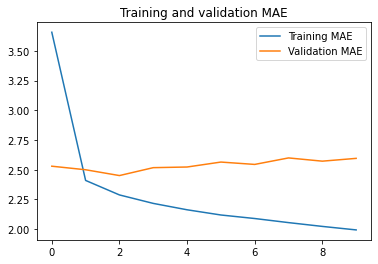

In [67]:
plot_history(history)